In [1]:
from astroquery.vizier import Vizier
from nsstools import NssSource #You likely need to install this package
import pandas as pd
from astropy.table import Table
from astropy.io import fits
from astropy.time import Time
from math import floor, log10
import matplotlib.pyplot as plt
import numpy as np
import os
from Dipper_Project_Functions import read_lightcurve_csv
from Dipper_Project_Functions import read_lightcurve_dat

# A bunch of helper functions

In [2]:
#Downloads the entry from vizier using the Gaia source ID
def query_gaia_orbit(source, catalog='I/357/tbosb1'):
    if catalog == 'I/357/tbosb1':
        vizier_columns = ['Source', 'Per', 'e_Per', 'Tperi', 'e_Tperi',
                          'ecc', 'e_ecc', 'Vcm', 'e_Vcm', 'K1', 'e_K1',
                          'omega', 'e_omega']
    else:
        raise NotImplementedError('Only SB1 catalog available')
    
    r = Vizier(catalog=catalog, columns=vizier_columns).query_constraints(
            Source=str(source))[0]
        
    r = r.to_pandas().iloc[0].to_dict()
    r['Source'] = source
    
    r['omega'] = r['omega'] * np.pi/180
    r['e_omega'] = r['e_omega'] * np.pi/180
            
    return r 

def plotparams(ax, labelsize=15):
    if isinstance(ax, np.ndarray):
        for a in ax.reshape(-1):
            plotparams(a)
        return

    ax.minorticks_on()
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(direction='in', which='both', labelsize=labelsize)
    ax.tick_params('both', length=8, width=1.8, which='major')
    ax.tick_params('both', length=4, width=1, which='minor')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
    return ax

#Helpful for rounding to sig figs
def round_val_err(val, err, err_upper=None):
    
    if err_upper is not None:
        return round_val_err_uneven(val, err, err_upper)
    else:
        n = int(-1*np.floor(np.log10(err)))

        if n < 0:
            return int(round(val, n)), int(round(err, n))
        else:
            return round(val, n), round(err, n)

def round_val_err_uneven(val, err_lower, err_upper):

    ndigits_lower = -int(floor(log10(abs(err_lower))))
    ndigits_upper = -int(floor(log10(abs(err_upper))))

    ndigits = np.max([ndigits_lower, ndigits_upper])

    if ndigits <= 0:
        val_string = str(int(round(val, ndigits)))
        upper_string = str(int(round(err_upper, ndigits)))
        lower_string = str(int(round(err_lower, ndigits)))
    else:
        val_string = '{0:.{1}f}'.format(val, ndigits)
        upper_string = '{0:.{1}f}'.format(err_upper, ndigits_upper)
        lower_string = '{0:.{1}f}'.format(err_lower, ndigits_lower)

    return r'$'+val_string+r'^{+'+upper_string+r'}_{-'+lower_string+r'}$'

#Kepler's equation
def eccentric_anomaly(M, e):

    max_iterations = 1000
    tolerance = 1e-7
    E = M
    for _ in range(max_iterations):
        f = E - e * np.sin(E) - M

        f_prime = 1 - e * np.cos(E)
        delta = f / f_prime
        E -= delta

        if np.abs(delta) < tolerance:
            return E

#Equation for RV variations
def rv_model(t, K, gamma, phi0, ecc, omega, period, omegadot=0):

    #omegadot is units of deg/yr
    #convert to rad/d * np.pi /180 /365

    cosw = np.cos(omega + t*omegadot*(np.pi/180)*(1/365))
    sinw = np.sin(omega + t*omegadot*(np.pi/180)*(1/365))

    M = ((2*np.pi*t)/period) - phi0
    E = np.zeros(len(M))
    for i in range(len(M)):
        Ei = eccentric_anomaly(M[i], ecc)
        if Ei is None:
            print('Here', M[i], ecc)
        E[i] = Ei

    cosf = ( np.cos(E) - ecc ) / ( 1-ecc*np.cos(E) )
    sinf = ( np.sqrt(1-ecc**2) * np.sin(E) ) / ( 1-ecc*np.cos(E))

    model = gamma + K * (cosw*cosf - sinw*sinf + ecc*cosw)

    return model

# Generating RV samples

In [3]:
source = 524241032396352768
asas_sn_id = 68720274411

In [4]:
df_scores = Table(fits.open('Gaia_DR3_SB1_clean_Scores.fits')[1].data).to_pandas()
df_nss = pd.read_csv('nss_table-result.csv')

In [5]:
#Gaia reports times relative to a reference time at the start of 2016
reference_jd = Time(2016.0, format='decimalyear').jd 

In [6]:
#Constructs the covariance matrix and draws samples
def generate_rv_samples(source, size):
    
    nss_source_object = NssSource(df_nss, indice=np.where(df_nss.source_id == source)[0][0])

    orbit_dict = query_gaia_orbit(source)

    key_mapper = {'period': 'Per', 'center_of_mass_velocity': 'Vcm', 'semi_amplitude_primary': 'K1',
              'eccentricity': 'ecc', 'arg_periastron': 'omega', 't_periastron': 'Tperi'}

    covmat = nss_source_object.covmat()
    median_values = [ orbit_dict[key_mapper[k]] for k in covmat.columns ]

    samples = np.random.multivariate_normal(mean=median_values, cov=covmat.values, size=size)

    return samples

In [7]:
#Equations to determine conjunction times
def _delta_t_infconj_perpass(period, ecc, per0):
    """
    time shift between inferior conjuction and periastron passage
    """
    #per0 in radians

    ups_sc = 3*np.pi/2-per0
    E_sc = 2*np.arctan( np.sqrt((1-ecc)/(1+ecc)) * np.tan(ups_sc/2) )
    M_sc = E_sc - ecc*np.sin(E_sc)
    return period*(M_sc/2./np.pi)


def t0_perpass_to_infconj(t0_perpass, period, ecc, per0):

    return t0_perpass + _delta_t_infconj_perpass(period, ecc, per0)

def _delta_t_supconj_perpass(period, ecc, per0):
    """
    time shift between superior conjuction and periastron passage
    """

    ups_sc = np.pi/2-per0
    E_sc = 2*np.arctan( np.sqrt((1-ecc)/(1+ecc)) * np.tan(ups_sc/2) )
    M_sc = E_sc - ecc*np.sin(E_sc)
    return period*(M_sc/2./np.pi)

def t0_perpass_to_supconj(t0_perpass, period, ecc, per0):

    return t0_perpass + _delta_t_supconj_perpass(period, ecc, per0)

In [8]:
def plot_rv_orbit(source, ax):
    
    ax = plotparams(ax)

    orbit_dict = query_gaia_orbit(source)

    tvals = np.linspace(-orbit_dict['Per']*1.2, 2.2*orbit_dict['Per'], int(1e5))
    samples = generate_rv_samples(source, 100)

    
    for s in samples:
        
        period, gamma, K1, ecc, omega, T0 = s
        omega  = omega*np.pi/180
        phi0 = 2*np.pi*T0 / period

        rvs = rv_model(tvals, K1, gamma, phi0, ecc, omega, period)

        ax.plot(tvals, rvs, color='xkcd:red', alpha=0.2)
    
    rvs_median = rv_model(tvals, orbit_dict['K1'], orbit_dict['Vcm'], 
                          2*np.pi*orbit_dict['Tperi']/orbit_dict['Per'],
                          orbit_dict['ecc'], orbit_dict['omega']*np.pi/180,
                          orbit_dict['Per'])
    ax.plot(tvals, rvs_median, color='black', lw=2)
    
    supconj = t0_perpass_to_supconj(orbit_dict['Tperi'], 
                                    orbit_dict['Per'], 
                                    orbit_dict['ecc'], 
                                    orbit_dict['omega']*np.pi/180)
    
    infconj = t0_perpass_to_infconj(orbit_dict['Tperi'], 
                                    orbit_dict['Per'], 
                                    orbit_dict['ecc'], 
                                    orbit_dict['omega']*np.pi/180)
    ax.axvline(supconj, color='gray', label='Superior Conjunction')
    ax.axvline(infconj, color='gray', ls='--', label='Inferior Conjunction')

    ax.set_xlabel('JD - 2016.0 [d]', fontsize=20)
    ax.set_ylabel('Radial Velocity [km/s]', fontsize=20)

    score = df_scores[df_scores.source_id_1 == source].clean_Scores.iloc[0]
    ax.text(.95, 1.0, r'$\mathcal{S} = ' + str(round(score, 2)) + r'$',
            ha='right', va='center', fontsize=20, transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='black'))

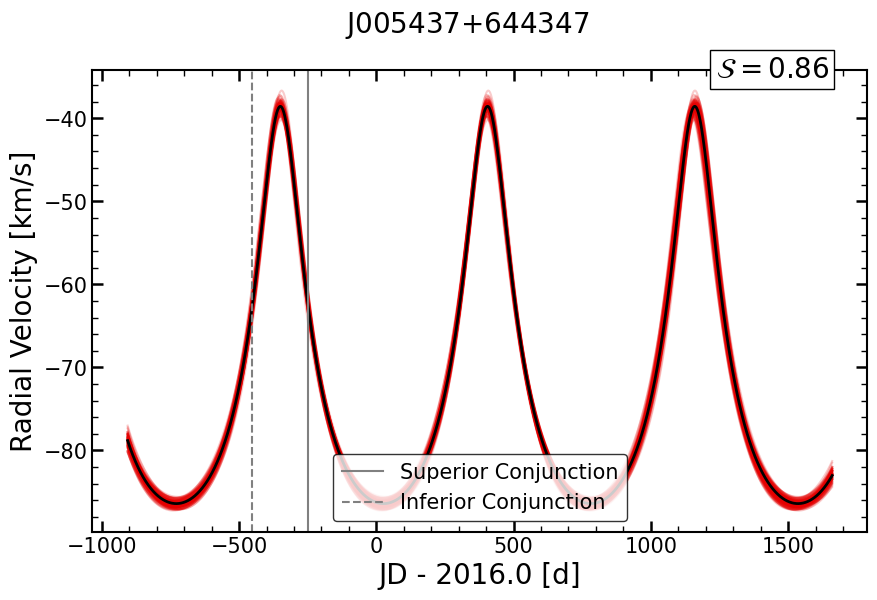

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

fig.suptitle('J005437$+$644347', size=20)

plot_rv_orbit(source, ax)

ax.legend(loc='lower center', fontsize=15, edgecolor='black')

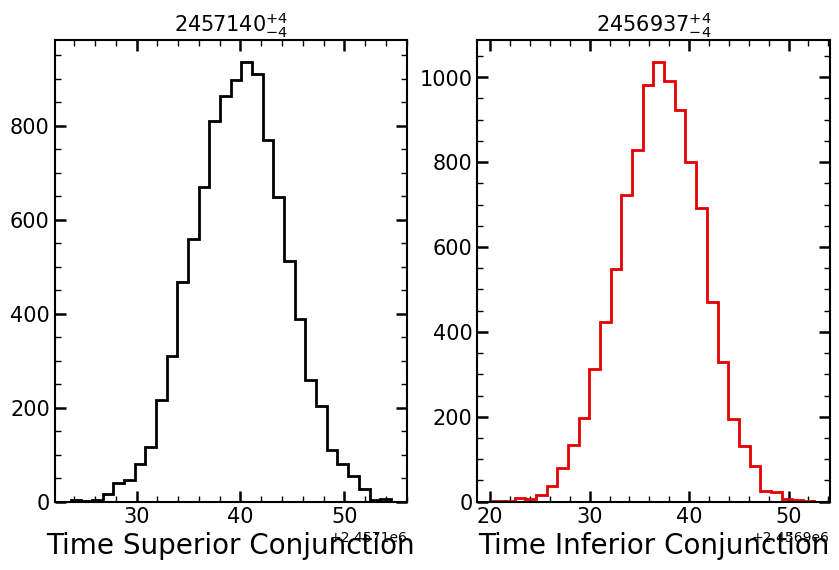

In [10]:
#Measure the uncertainty in the conjunction times

samples = generate_rv_samples(source, 10000)
supconjs = []
infconjs = []
for s in samples:

    period, gamma, K1, ecc, omega, T0 = s
    omega  = omega*np.pi/180
    phi0 = 2*np.pi*T0 / period
    
    supconj = t0_perpass_to_supconj(T0, period, ecc, omega)
    infconj = t0_perpass_to_infconj(T0, period, ecc, omega)
    
    supconjs.append(supconj + reference_jd)
    infconjs.append(infconj + reference_jd)
    
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
for a in ax: a = plotparams(a)
    
ax[0].hist(supconjs, bins=30, histtype='step', lw=2, color='black')
ax[1].hist(infconjs, bins=30, histtype='step', lw=2, color='xkcd:red')

ax[0].set_xlabel('Time Superior Conjunction', fontsize=20)
ax[1].set_xlabel('Time Inferior Conjunction', fontsize=20)

for a, l in zip(ax, [supconjs, infconjs]):
    
    med = np.nanmedian(l)
    lower_err = med - np.nanquantile(l, 0.16)
    upper_err = np.nanquantile(l, 0.84) - med
    
    
    a.set_title(round_val_err(med, lower_err, upper_err), fontsize=15)

# Do we see the eclipse at the conjunction time?

if you uncomment the lines that calculate the error in the conjunction times,
you can see that the uncertainties are so large they actually do encompass the observed conjunction time
for this target

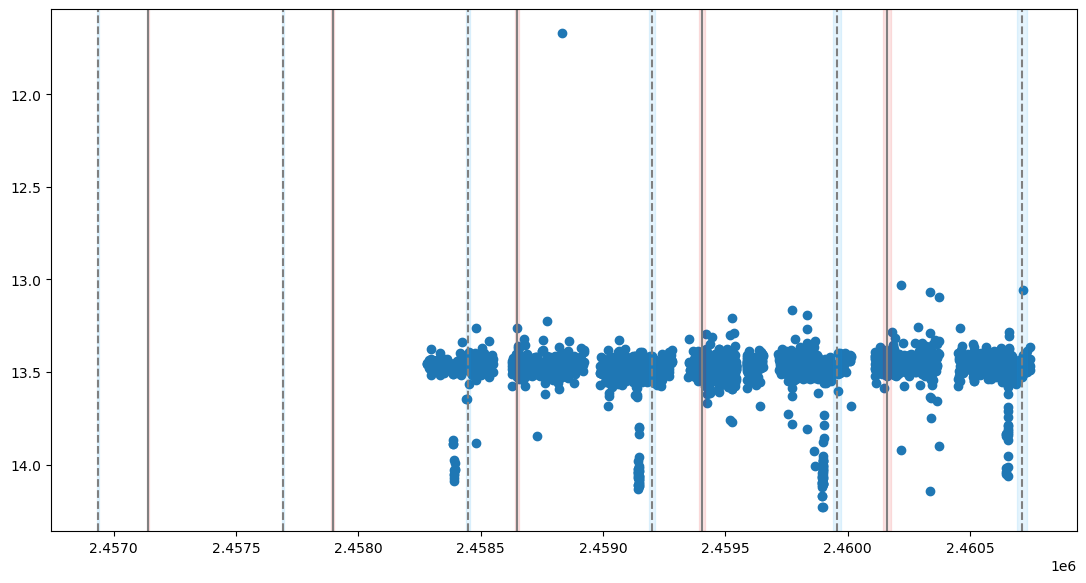

In [11]:
vv, vs = read_lightcurve_csv(asas_sn_id=asas_sn_id, guide='Updated_LC_data') #Insert your light curve code here
vs = vs.loc[vs.Mag < 20].reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.subplots_adjust(top=.98, right=.98)
#vs.plot_full(ax=ax)

ax.scatter(vs['JD'], vs['Mag'])
ax.invert_yaxis()

xlim = ax.get_xlim()

orbit_dict = query_gaia_orbit(source)
period = orbit_dict['Per']
period_err = orbit_dict['e_Per']

n = 0
while np.nanmedian(supconjs) + n*period < xlim[1]:
    
    ax.axvline(np.nanmedian(supconjs)+n*period, color='gray', ls='-')

    std = np.sqrt( np.nanstd(supconjs)**2 + n**2 * period_err**2 )
    ax.axvspan(np.nanmedian(supconjs)+n*period - std, 
               np.nanmedian(supconjs)+n*period + std, color='xkcd:red', alpha=0.1)
    n += 1

n = 0
while np.nanmedian(infconjs) + n*period < xlim[1]:
    
    ax.axvline(np.nanmedian(infconjs)+n*period, color='gray', ls='--')
    std = np.sqrt( np.nanstd(infconjs)**2 + n**2 * period_err**2 )
    ax.axvspan(np.nanmedian(infconjs)+n*period - std, 
               np.nanmedian(infconjs)+n*period + std, color='xkcd:azure', alpha=0.1)
    
    n += 1


In [12]:
print(orbit_dict)

{'Source': 524241032396352768, 'Per': 754.8735796386283, 'e_Per': 3.8169901, 'Tperi': -349.2392340416279, 'e_Tperi': 5.1059155, 'ecc': 0.37258541550379165, 'e_ecc': 0.015654562, 'Vcm': -71.3983442466097, 'e_Vcm': 0.2548016, 'K1': 23.92232798439115, 'e_K1': 0.38182643, 'omega': 0.4352867863380711, 'e_omega': 0.04742640423243656}
